# 1. Data and module import

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('../timeseries-forecasting/salesdata.csv', index_col='OrderDate', parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1127 entries, 2019-01-01 to 2022-01-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   QtyOrdered  1127 non-null   int64
dtypes: int64(1)
memory usage: 17.6 KB


# 2. EDA (Exploratory Data Analysis)

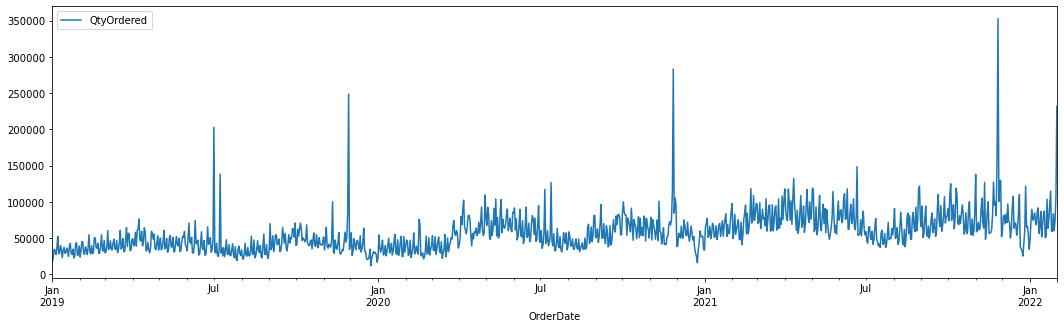

In [21]:
df.plot(figsize=(18,5));

### Check stationarity of time series using Dickey-Fuller test that assumes data is non-stationary.
- Data needs to be stationary for ARIMA model to work
- With p-value <= 0.05 we can reject null hypothesis (data is non-stationary) and accept it is stationary

In [22]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(df)
print(f'p-value: {results[1]}')


p-value: 0.10094479559280162


p-value > 0.05 that means data is non-stationary and we need to transform it into stationary data using differencing method

In [23]:
df_stationary = df.diff().dropna()

In [24]:
results = adfuller(df_stationary)
print(f'p-value: {results[1]}')

p-value: 3.7554294216673787e-19


That's about 0.00000000000000000037, which means p-value < 0.05. Data is stationary

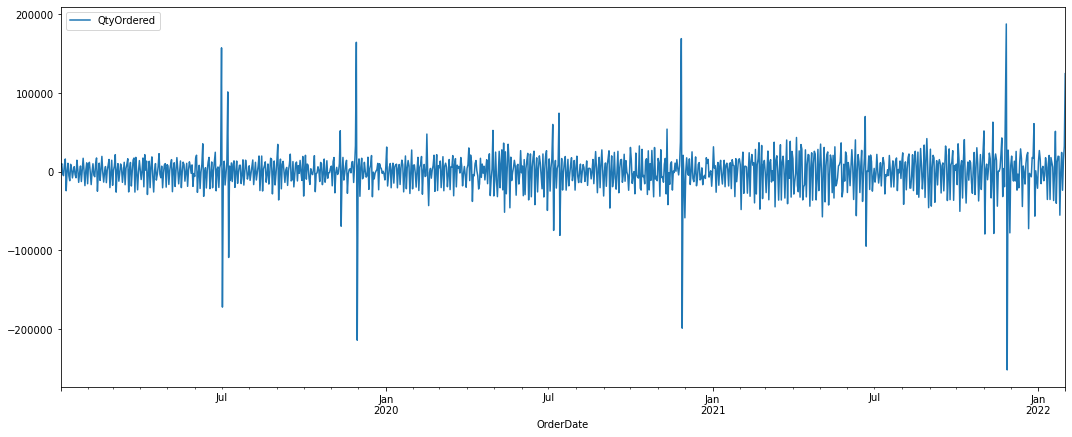

In [25]:
df_stationary.plot(figsize=(18,7));

There is also <b>ndiffs</b> function in pmdarima.arima.utils module that will help us identify the order of differencing - how many times should we difference data set in order to achieve stationarity

In [30]:
from pmdarima.arima.utils import ndiffs

print('# of differencing: ' + str(ndiffs(df.QtyOrdered, test='adf')))

# of differencing: 0


We can see, however, that we get a different result and according to <b>ndiffs</b> data is stationary. I will be using the results from ADFuller test from **statsmodel**

# 3. Finding right ***p, q, d*** terms for the ARIMA model

 ***p*** - order of Auto Regressive (AR) terms. Number of lags to be used for prediction
 
 We can use Partial Autocorrelation (correlation between time series and its lags) plot to find sufficient number of lags or AR terms 

C:\Users\208896\.conda\envs\timeseries-forecasting\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


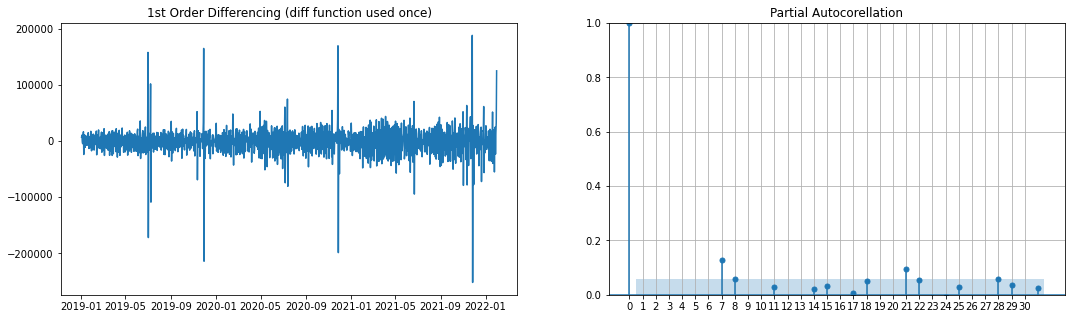

In [44]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(df_stationary)
ax1.set_title('1st Order Differencing (diff function used once)')
plot_pacf(df_stationary, ax=ax2)
ax2.set_title('Partial Autocorellation')
ax2.grid(True)
ax2.set_xticks(range(0,31))
ax2.set_ylim(0, 1); # I'm only focusing on positive correlation

We can see that lag 7 could be sufficient as a ***p*** term as it's above the significance line

In [127]:
# Make predictions for last 25 values
results = model.fit()# Make in-sample prediction
forecast = results.get_prediction(start=-31)
# forecast mean
mean_forecast = forecast.predicted_mean

mean_forecast

C:\Users\208896\.conda\envs\timeseries-forecasting\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\208896\.conda\envs\timeseries-forecasting\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\208896\.conda\envs\timeseries-forecasting\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2022-01-01    37446.883141
2022-01-02    64903.311820
2022-01-03    84267.459493
2022-01-04    63790.541467
2022-01-05    58557.030603
2022-01-06    77050.479265
2022-01-07    69224.285757
2022-01-08    55664.173578
2022-01-09    77589.023496
2022-01-10    88921.256831
2022-01-11    68721.829131
2022-01-12    60677.748864
2022-01-13    80375.369259
2022-01-14    74181.430225
2022-01-15    53862.576409
2022-01-16    77075.699786
2022-01-17    84621.068402
2022-01-18    63936.249635
2022-01-19    59300.676365
2022-01-20    74919.445130
2022-01-21    75612.909428
2022-01-22    58553.056436
2022-01-23    82339.822210
2022-01-24    88333.478940
2022-01-25    71689.789308
2022-01-26    66635.219327
2022-01-27    84137.552967
2022-01-28    71698.524167
2022-01-29    56819.229684
2022-01-30    85399.726203
2022-01-31    98741.528825
Freq: D, Name: predicted_mean, dtype: float64

In [128]:
# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()
confidence_intervals

,lower QtyOrdered,upper QtyOrdered
2022-01-01,-708.776689,75602.542971
2022-01-02,26747.652416,103058.971223
2022-01-03,46111.800513,122423.118474
2022-01-04,25634.882907,101946.200026
2022-01-05,20401.372462,96712.688744
2022-01-06,38894.821540,115206.136990
2022-01-07,31068.628446,107379.943069
2022-01-08,17508.516677,93819.830479
2022-01-09,39433.367003,115744.679988
2022-01-10,50765.600744,127076.912918


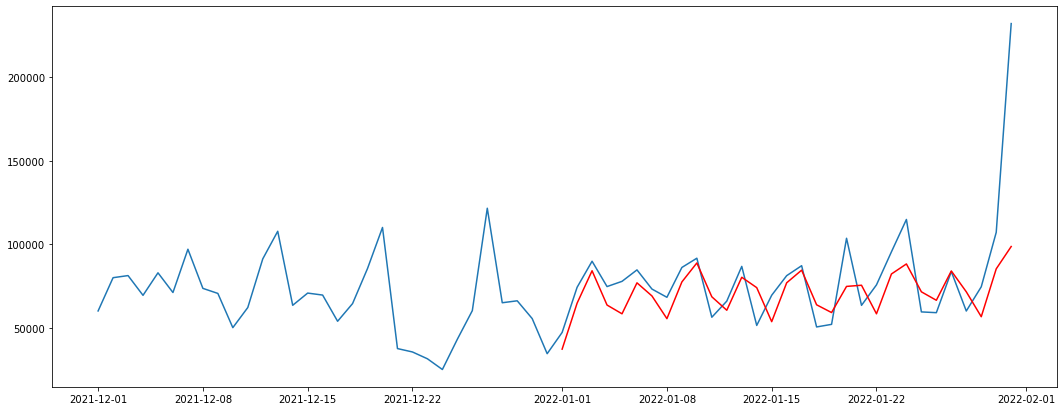

In [129]:
plt.figure(figsize=(18,7))

# Plot observed data
df_2021 = df.loc['2021-12':]
plt.plot(df_2021.index, df_2021, label='observed')

plt.plot(mean_forecast.index,
         mean_forecast,
         color='red',
         label='forecast')
# Shade uncertainty area
#plt.fill_between(df_test.index, lower_limits, upper_limits, color='pink')
plt.show()
